# Partial differential equations solver (task N1)

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

from numpy import sqrt, exp, sinh

## Equation statement

In [3]:
# interval
a, b = 2, 5
# boundary conditions
a1, b1, g1 = 0, 1, 0
a2, b2, g2 = 1, -2, 0

p = lambda t: 0.5 / (t - 1)
q = lambda t: np.zeros_like(t)
f = lambda t: 5 * sqrt(t - 1)

# exact solution
# exact    = lambda x: 

## ODE solution

In [4]:
def solve(t, value, derivative):
    """solve equation for 
    y (a) = value
    y'(a) = derivative
    """
    
    from scipy.integrate import odeint
    
    # x = (y, y')

    def func(x, t):
        # y'' + p*y' + q*y = f; x0 = y, x1 = y'
        return [
            x[1],
            f(t) - p(t)*x[1] - q(t)*x[0]
        ]
    
    x0 = [value, derivative]
    return odeint(func, x0, t)

## Plotting routines

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot(x = None, y = None, figsize = (20, 14), s = 27, lw = 2, ls = '-', edgecolor = 'black', restart = True, label = None, line = True, scatter = False, *args, **kwargs):
    """Nice simple wrapper around the default matplotlib plotter"""
    
    params = { 
    'font.size'           : 20, 
    'figure.figsize'      : figsize,
    'font.family'         : 'DejaVu Sans Mono',
    'axes.titlepad'       : 20
    }   

    plt.rcParams.update(params)

    # for quick plots
    if x is None:
        x = range(len(y))

    # use the same canvas
    if restart or not hasattr(plot, 'ax'):
        fig, ax = plt.subplots()
        plot.ax  = ax
        plot.fig = fig 
    
        ax.grid(color='#e5e5e5', linestyle='--', linewidth=1)
        ax.set_facecolor((0.995, 0.995, 1)) 
    
    
    ax  = plot.ax
    fig = plot.fig
    
    if scatter:
        ax.scatter(x, y, s=s, edgecolor = edgecolor, label = label, zorder = 100, *args, **kwargs) 
    if line:
        ax.plot(x, y, linestyle=ls, lw=lw, markersize=7, label = '_nolegend_' if scatter else label , zorder = 99, *args, **kwargs)
    
    
    return ax

## Shooting

In [6]:
def residual(t, value, derivative):
    residual.n += 1
    n = residual.n
    
    sol = solve(t, value, derivative)
    y   = sol[:, 0]
    y_x = sol[:, 1]
    
    ax = plot(t, y, restart = False, ls= '--', lw = 1)
    
    if n < 8:
        ax.text(b-0.03, y[-1], s = "n = {:d}".format(n), fontsize = 15)
        
    return a2*y[-1] + b2*y_x[-1] - g2

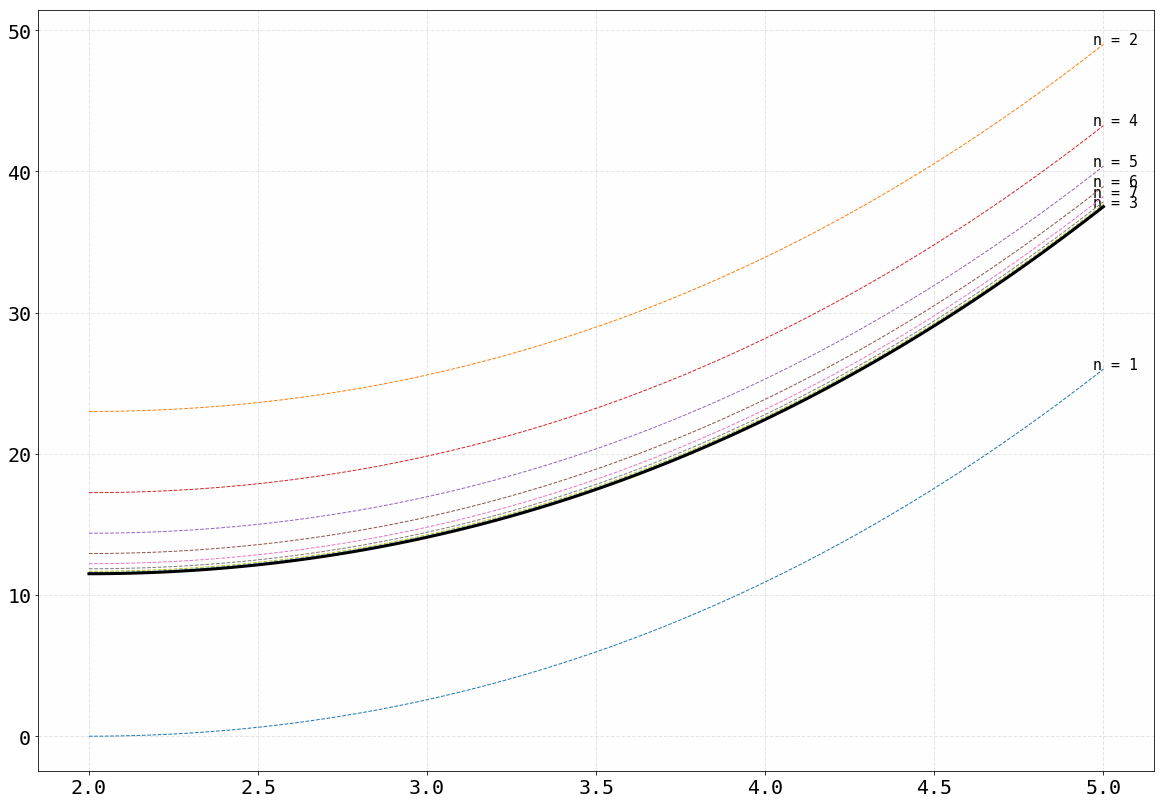

In [18]:
residual.n = 0

plot(restart = True, y = [1], line = False)
N = 100
t = np.linspace(a, b, N)
derivative = 0
    
from scipy import optimize
val = sc.optimize.bisect(lambda x: residual(t, x, derivative), 0, 23, xtol = 0.01)

sol = solve(t, val, derivative)
y   = sol[:, 0]

plot(t, y, restart = False, color='black', lw=3, label = 'Shooting')

# exact solution
# plot(t, exact(t), restart = False, color='red', lw=3, label = 'Exact').legend();

## TDM

In [13]:
# helper class
class Dim:
    def __init__(self, min, max, N):
        self.h   = float(max - min) / N
        self.min = float(min)
        self.max = float(max)
        self.N  = N + 1 # for convinience

    def __getitem__(self, n):
        return self.min + self.h * n

In [14]:
def TDM(x):
    A = np.zeros((x.N, x.N))
    B = np.zeros(x.N)

    # mesh
    X = np.linspace(a, b, x.N)
    P, Q, F = p(X), q(X), f(X)

    A[0, 0] = a1 * x.h - b1
    A[0, 1] = b1
    B[0]    = g1 * x.h

    for n in range(1, x.N - 1):
        A[n, n+1] =  1 + P[n] *  x.h/2
        A[n, n]   = -2 + Q[n] * (x.h**2)
        A[n, n-1] =  1 - P[n] *  x.h/2
        B[n]      =  0 + F[n] * (x.h**2)

    A[x.N - 1, x.N - 2] = -b2
    A[x.N - 1, x.N - 1] =  b2 + a2 * x.h
    B[x.N - 1]          =  g2 * x.h
    
    return X, np.linalg.solve(A, B)

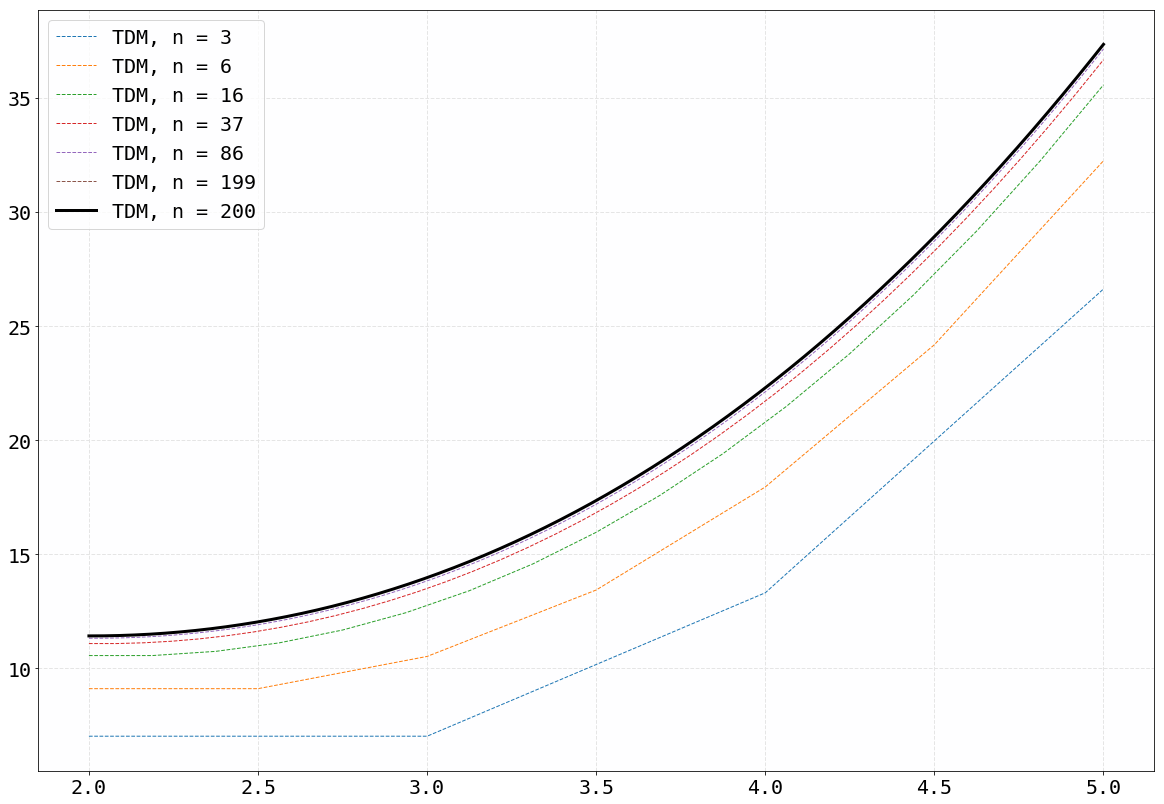

In [15]:
ax = plot(restart = True, y = [1], line = False)
# exact solution
# plot(X, exact(X), color='red', lw=3, label = 'Exact', restart = False)

N_max = 200
for N in map(int, np.logspace(np.log(3), np.log(N_max), 6, base = np.e)):
    # solution:
    x = Dim(min = a, max = b, N = N)
    X, Y = TDM(x)

    plot(X, Y, lw=1, ls = '--', label = f'TDM, n = {N}', restart = False)
    
x = Dim(min = a, max = b, N = N_max)
X, Y = TDM(x)
plot(X, Y, lw=3, label = f'TDM, n = {N_max}', restart = False, color = 'black')
    
ax.legend();